# 随机梯度下降
在深度学习中，目标函数通常是训练数据集中每个样本的损失函数的平均值，给定n个样本的训练集，如果使用梯度下降法的话，则每个自标量迭代的计算代价为O（n），随n线性增长，当训练数据集较大的时候，每次迭代的梯度下降计算代价很高。

使用sgd就可以降低每次迭代时的计算代价，在随机梯度下降的每次迭代中，我们对数据随机采样一个样本，使用样本的梯度来更新网络参数，从而使计算代价降低为O（1）

此外，随机梯度是对完整体度的无偏估计，这意味着平均而言，随机梯度是对梯度的良好估计


epoch 50, x1: -0.018806, x2: 0.065564


D:\devloper\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


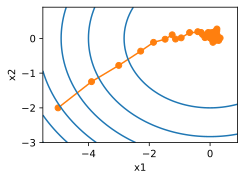

In [1]:
import sys
sys.path.append("../")
from pltutils import show_trace_2d,train_2d
import torch as t

# 将随机梯度下降和梯度下降相比较
def f(x1,x2):
    return x1**2+2*x2**2
def f_grad(x1,x2):
    return 2*x1,4*x2

def sgd(x1,x2,s1,s2,f_grad):
    g1,g2=f_grad(x1,x2)

    g1+=t.normal(0.,1,(1,))
    g2+=t.normal(0.,1,(1,))
    eta_t=eta*lr()
    return (x1-eta_t*g1,x2-eta_t*g2,0,0)

def constant_lr():
    return 1
eta=0.1
lr =constant_lr
show_trace_2d(f,train_2d(sgd,steps=50,f_grad=f_grad))

可以看到我们在随机梯度下降中的效果不如梯度下降[(代码在此)](gradientDescent.ipynb)平滑，这正是因为梯度的随机性质造成的。

即使我们接近了最小值，我们还是受到了噪声的影响，最后的结果并不是非常理想，经过额外的步骤它还是变差了，我们只能够选择不同的eta来解决上述问题，那么又要动态地调整学习率了。

epoch 500, x1: -0.886518, x2: -0.027009


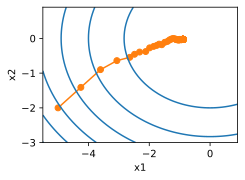

In [16]:
import math

def exponetial_lr():
    global t1
    t1+=1
    return math.exp(-0.1 * t1)
t1=1
lr=exponetial_lr
show_trace_2d(f,train_2d(sgd,steps=500,f_grad=f_grad))

epoch 50, x1: 0.080458, x2: -0.013152


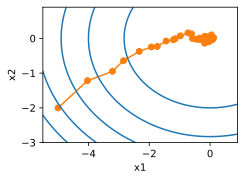

In [17]:
#使用多项式衰减
def polynominal_lr():
    global t1
    t1+=1
    return (1+0.1*t1)**(-0.5)

t1=1
lr =polynominal_lr
show_trace_2d(f,train_2d(sgd,steps=50,f_grad=f_grad))

# 小批量随机梯度下降

目前小批量随机梯度下降成为主流，因为它充分利用了计算机硬件的平行性能。

小批量的随机梯度下降在实践t采样一个随机子集，然后进行梯度计算和梯度下降，同样，这是一个无偏的近似，但降低了方差。


In [18]:
# 使用小批量的决策核心是计算效率
%matplotlib inline
import numpy as np
import torch as t
import torch.nn as nn
from pltutils import *

timer = Timer()

A= t.zeros(256,256)
B = t.randn(256,256)
C=t.randn(256,256)


timer.start()
for i in range(256):
    for j in range(256):
        A[i,j]=t.dot(B[i,:],C[:,j])
timer.stop()

0.8681769371032715

In [19]:
# 更快的策略是执行按列分配
timer.start()
for j in range(256):
    A[:,j]=t.mv(B,C[:,j])
timer.stop()

0.011451244354248047

In [20]:
#最有效的方法是在一个区块中执行整个操作
timer.start()
A=t.mm(B,C)
print(timer.stop())

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')


0.0010008811950683594
performance in Gigaflops: element 2.304, column 174.654, full 1998.239


In [21]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
print(timer.stop())
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

# 可以看到分块的话性能更上面的整个操作是差不多的

0.0029001235961914062
performance in Gigaflops: block 689.626


# 从零开始实现小批量梯度下降

In [22]:
def sgd(params,states,hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr']*p.grad)
        p.grad.data.zero_()

def train_ch11(trainer_fn,states,hyperparams,data_iter,features_dim,num_epochs=2):
    # init model
    w = t.normal(mean=0.,std=0.01,size=(features_dim,1),requires_grad=True)
    b = t.zeros((1),requires_grad=True)

    net,loss = lambda X:linreg(X,w,b),squared_loss
    # training procedure
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n,timer = 0,Timer()
    for _ in range(num_epochs):
        for X, y  in data_iter:
            l = loss(net(X),y).mean()
            l.backward()

            trainer_fn([w,b],states,hyperparams)
            n+=X.shape[0]
            if n%200==0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]


loss: 0.245, 0.041 sec/epoch


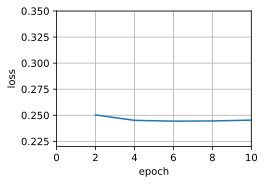

In [23]:
def train_sgd(lr,batch_size,num_epochs=2):
    data_iter,feature_dim =get_data_ch11(batch_size)
    return train_ch11(
        sgd,None,{"lr":lr},data_iter,feature_dim,num_epochs)
gd_res=train_sgd(1,1500,10)

loss: 0.243, 0.046 sec/epoch


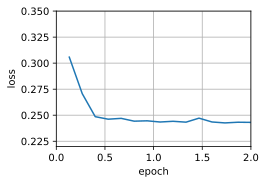

In [24]:
sgd_res = train_sgd(0.005, 1)


loss: 0.244, 0.002 sec/epoch


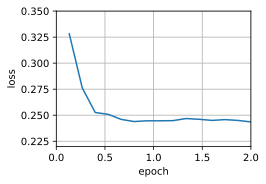

In [25]:
mini1_res = train_sgd(.4, 100)


loss: 0.244, 0.007 sec/epoch


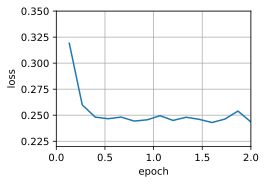

In [26]:
mini2_res = train_sgd(.05, 10)


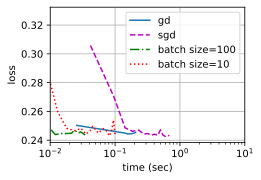

In [27]:
set_figsize([6, 3])
plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
plt.gca().set_xscale('log')